In [1]:
# %% [markdown]
# # test_model.ipynb — Unified LONG + SHORT classifier (TEST only)
#
# Standalone TEST runner:
# - needs only: `prepared/long_test.npz`, `prepared/short_test.npz`, `prepared/scaler_unified.json`
# - loads: `models/unified_long_short_classifier.pt`
# - runs the same TEST-only evaluations as `model_trainer.ipynb` (no train/valid required)


In [2]:
# %%
import os
import json
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
)

# Reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)


Using device: cuda


In [3]:
# %% [markdown]
# ## 1. Paths and basic checks


In [4]:
# %%
PREPARED_DIR = Path("./prepared")
MODEL_DIR    = Path("./models")

SCALER_PATH = PREPARED_DIR / "scaler_unified.json"
MODEL_PATH  = MODEL_DIR / "unified_long_short_classifier.pt"

for p in [PREPARED_DIR, MODEL_DIR]:
    assert p.exists(), f"Missing directory: {p.resolve()}"

for p in [
    SCALER_PATH,
    MODEL_PATH,
    PREPARED_DIR / "long_test.npz",
    PREPARED_DIR / "short_test.npz",
]:
    assert p.exists(), f"Missing file: {p.resolve()}"

print("OK - found prepared test NPZs, scaler json, and saved model.")


OK - found prepared test NPZs, scaler json, and saved model.


In [5]:
# %% [markdown]
# ## 2. (Optional) Load scaler metadata (shape sanity)
#
# The prepared NPZ files are **already standardized** by `data_prep.ipynb`,
# but we load the scaler JSON to confirm expected (T, F, S).


In [6]:
# %%
scaler = json.loads(SCALER_PATH.read_text())

T_expected = int(scaler["T"])
F_expected = int(scaler["F"])
S_expected = int(scaler["S"])          # snapshot features WITHOUT is_short
print(f"Scaler metadata: T={T_expected}, F={F_expected}, S(snapshot)={S_expected}")

print("Snapshot columns:", len(scaler.get("snapshot_cols", [])))
print("Series bases:", len(scaler.get("series_bases", [])))


Scaler metadata: T=160, F=18, S(snapshot)=17
Snapshot columns: 17
Series bases: 18


In [7]:
# %% [markdown]
# ## 3. Load and combine TEST split (LONG + SHORT)
#
# Same logic as in `model_trainer.ipynb`:
# - load `long_test.npz` and `short_test.npz`
# - extend snapshot with `is_short` (0=LONG, 1=SHORT)
# - concatenate and shuffle inside split (deterministic)


In [8]:
# %%
def load_direction_npz(direction: str, split: str):
    """
    direction: 'long' or 'short'
    split: 'train', 'valid', 'test'
    Returns:
        X_series:   (N, T, F)
        X_snapshot:(N, S)
        y_usd:     (N,)
        meta:      dict with sample_id, timestamp, direction, exit_reason
    """
    path = PREPARED_DIR / f"{direction}_{split}.npz"
    with np.load(path, allow_pickle=True) as z:
        X_series   = z["X_series"]
        X_snapshot = z["X_snapshot"]
        y_usd      = z["y"]

        sample_id   = np.array(z["sample_id"]).astype(str)
        timestamp   = np.array(z["timestamp"]).astype(str)
        direction_s = np.array(z["direction"]).astype(str)
        exit_reason = np.array(z["exit_reason"]).astype(str)

        meta = {
            "sample_id":  sample_id,
            "timestamp":  timestamp,
            "direction":  direction_s,
            "exit_reason": exit_reason,
        }

    print(
        f"[{direction.upper()}] {split}: "
        f"X_series={X_series.shape}, X_snapshot={X_snapshot.shape}, y={y_usd.shape}, "
        f"y_mean={y_usd.mean():.4f}, y_std={y_usd.std():.4f}"
    )
    return X_series, X_snapshot, y_usd, meta


def load_combined_split(split: str):
    """
    Load LONG and SHORT NPZs for the given split, extend snapshot with is_short,
    and concatenate. Returns:
        X_series:   (N_total, T, F)
        X_snapshot:(N_total, S+1)  (original snapshot + is_short flag)
        y_usd:     (N_total,)
        y_bin:     (N_total,)  0/1 label: 1 if PnL>0, else 0
        is_short:  (N_total,)  0 for LONG trades, 1 for SHORT trades
        meta:      dict with sample_id, timestamp, direction, exit_reason
    """
    # LONG
    Xs_L, Xp_L, y_L, meta_L = load_direction_npz("long", split)
    N_L = Xs_L.shape[0]
    is_short_L = np.zeros((N_L, 1), dtype=np.float32)

    # SHORT
    Xs_S, Xp_S, y_S, meta_S = load_direction_npz("short", split)
    N_S = Xs_S.shape[0]
    is_short_S = np.ones((N_S, 1), dtype=np.float32)

    # Extend snapshot with is_short flag
    Xp_L_ext = np.concatenate([Xp_L.astype(np.float32), is_short_L], axis=1)
    Xp_S_ext = np.concatenate([Xp_S.astype(np.float32), is_short_S], axis=1)

    # Combine
    X_series   = np.concatenate([Xs_L, Xs_S], axis=0).astype(np.float32)
    X_snapshot = np.concatenate([Xp_L_ext, Xp_S_ext], axis=0).astype(np.float32)
    y_usd      = np.concatenate([y_L, y_S], axis=0).astype(np.float32)
    y_bin      = (y_usd > 0.0).astype(np.float32)
    is_short   = np.concatenate([
        np.zeros(N_L, dtype=np.int64),
        np.ones(N_S,  dtype=np.int64)
    ], axis=0)

    # Meta join
    meta = {
        "sample_id":  np.concatenate([meta_L["sample_id"],  meta_S["sample_id"]]),
        "timestamp":  np.concatenate([meta_L["timestamp"],  meta_S["timestamp"]]),
        "direction":  np.concatenate([meta_L["direction"],  meta_S["direction"]]),
        "exit_reason":np.concatenate([meta_L["exit_reason"],meta_S["exit_reason"]]),
    }

    # Shuffle inside the split (just to avoid "all long then all short") – deterministic
    rng = np.random.default_rng(SEED + hash(split) % 10000)
    idx = rng.permutation(X_series.shape[0])

    X_series   = X_series[idx]
    X_snapshot = X_snapshot[idx]
    y_usd      = y_usd[idx]
    y_bin      = y_bin[idx]
    is_short   = is_short[idx]
    meta = {k: v[idx] for k, v in meta.items()}

    print(
        f"[COMBINED] {split}: X_series={X_series.shape}, "
        f"X_snapshot={X_snapshot.shape}, y_usd_mean={y_usd.mean():.4f}, "
        f"pos_rate={y_bin.mean():.3f}, short_frac={is_short.mean():.3f}"
    )

    return X_series, X_snapshot, y_usd, y_bin, is_short, meta

X_te_series, X_te_snap, y_te_usd, y_te_bin, is_short_te, meta_te = load_combined_split("test")

T = int(X_te_series.shape[1])
F = int(X_te_series.shape[2])
S = int(X_te_snap.shape[1])  # snapshot incl. is_short

print(f"\nTEST shapes: X_series={X_te_series.shape}, X_snapshot={X_te_snap.shape}")
print(f"Derived: T={T}, F={F}, S(snapshot incl. is_short)={S}")

# Sanity vs scaler
assert T == T_expected, f"T mismatch: test={T} vs scaler={T_expected}"
assert F == F_expected, f"F mismatch: test={F} vs scaler={F_expected}"
assert S == (S_expected + 1), f"S mismatch: test={S} vs scaler+is_short={S_expected+1}"


[LONG] test: X_series=(462, 160, 18), X_snapshot=(462, 17), y=(462,), y_mean=9.3164, y_std=175.2634
[SHORT] test: X_series=(463, 160, 18), X_snapshot=(463, 17), y=(463,), y_mean=8.3856, y_std=134.1407
[COMBINED] test: X_series=(925, 160, 18), X_snapshot=(925, 18), y_usd_mean=8.8505, pos_rate=0.455, short_frac=0.501

TEST shapes: X_series=(925, 160, 18), X_snapshot=(925, 18)
Derived: T=160, F=18, S(snapshot incl. is_short)=18


In [9]:
# %% [markdown]
# ## 4. Dataset + DataLoader (TEST only)


In [10]:
# %%
class TradesClsDataset(Dataset):
    def __init__(self, X_series, X_snapshot, y_usd, y_bin, is_short):
        """
        X_series:   (N, T, F)
        X_snapshot:(N, S) - includes is_short as last column
        y_usd:     (N,)   net PnL in USD
        y_bin:     (N,)   0/1 label: PnL>0
        is_short:  (N,)   0=LONG, 1=SHORT
        """
        self.X_series = X_series.astype(np.float32)
        self.X_snapshot = X_snapshot.astype(np.float32)
        self.y_usd = y_usd.astype(np.float32)
        self.y_bin = y_bin.astype(np.float32)
        self.is_short = is_short.astype(np.int64)

    def __len__(self):
        return self.X_series.shape[0]

    def __getitem__(self, idx):
        ts = self.X_series[idx]           # (T, F)
        ts = np.transpose(ts, (1, 0))     # (F, T) for Conv1d
        snap = self.X_snapshot[idx]       # (S,)
        label = self.y_bin[idx]
        y_usd = self.y_usd[idx]
        is_sh = self.is_short[idx]
        return (
            torch.from_numpy(ts),
            torch.from_numpy(snap),
            torch.tensor(label, dtype=torch.float32),
            torch.tensor(y_usd, dtype=torch.float32),
            torch.tensor(is_sh, dtype=torch.int64),
        )

BATCH_SIZE = 64
test_dataset = TradesClsDataset(X_te_series, X_te_snap, y_te_usd, y_te_bin, is_short_te)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

print("Test dataset size:", len(test_dataset))


Test dataset size: 925


In [11]:
# %% [markdown]
# ## 5. Model architecture (same as model_trainer)


In [12]:
# %%
class TCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=5, dilation=1, dropout=0.1):
        super().__init__()
        padding = (kernel_size - 1) // 2 * dilation

        self.conv1 = nn.Conv1d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            padding=padding,
            dilation=dilation,
        )
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(
            out_channels,
            out_channels,
            kernel_size=kernel_size,
            padding=padding,
            dilation=dilation,
        )
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.downsample = None
        if in_channels != out_channels:
            self.downsample = nn.Conv1d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        # x: (batch, channels, time)
        residual = x

        out = self.conv1(x)
        out = self.relu1(out)
        out = self.dropout1(out)

        out = self.conv2(out)
        out = self.relu2(out)
        out = self.dropout2(out)

        if self.downsample is not None:
            residual = self.downsample(residual)

        out = out + residual
        out = torch.relu(out)
        return out


class TemporalConvNet(nn.Module):
    def __init__(self, in_channels=18, hidden_channels=64, num_layers=3,
                 kernel_size=5, dropout=0.1):
        super().__init__()
        layers = []
        channels = in_channels
        for i in range(num_layers):
            dilation = 2 ** i  # 1, 2, 4
            layers.append(
                TCNBlock(
                    channels,
                    hidden_channels,
                    kernel_size=kernel_size,
                    dilation=dilation,
                    dropout=dropout,
                )
            )
            channels = hidden_channels
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        # x: (batch, channels, time)
        out = self.network(x)
        out = out.mean(dim=2)  # global average pooling
        return out


class SnapshotMLP(nn.Module):
    def __init__(self, in_features, hidden=64, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)


class TradeClassifierUnified(nn.Module):
    def __init__(self,
                 series_channels,
                 snapshot_features,
                 tcn_hidden=64,
                 tcn_layers=3,
                 mlp_hidden=64,
                 head_hidden=64,
                 dropout=0.1):
        super().__init__()
        self.tcn = TemporalConvNet(
            in_channels=series_channels,
            hidden_channels=tcn_hidden,
            num_layers=tcn_layers,
            kernel_size=5,
            dropout=dropout,
        )
        self.snap_mlp = SnapshotMLP(
            in_features=snapshot_features,
            hidden=mlp_hidden,
            dropout=dropout,
        )
        combined_in = tcn_hidden + mlp_hidden
        self.head = nn.Sequential(
            nn.Linear(combined_in, head_hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(head_hidden, 1),  # single logit
        )

    def forward(self, x_series, x_snapshot):
        # x_series:   (batch, F, T)
        # x_snapshot:(batch, S)
        series_emb = self.tcn(x_series)
        snap_emb   = self.snap_mlp(x_snapshot)
        combined   = torch.cat([series_emb, snap_emb], dim=1)
        logits     = self.head(combined).squeeze(-1)
        return logits


In [13]:
# %% [markdown]
# ## 6. Load saved model checkpoint

In [14]:
# %%
ckpt = torch.load(MODEL_PATH, map_location=DEVICE)

if isinstance(ckpt, dict) and "model_state_dict" in ckpt:
    state_dict = ckpt["model_state_dict"]
    cfg = ckpt.get("config", {})
else:
    # fallback: state_dict-only save
    state_dict = ckpt
    cfg = {}

if isinstance(cfg, dict) and cfg:
    print("Checkpoint config:", cfg)
else:
    print("No config found in checkpoint (this is OK).")

# Build model with the same hyperparams as training (hardcoded in model_trainer)
model = TradeClassifierUnified(
    series_channels=F,
    snapshot_features=S,
    tcn_hidden=64,
    tcn_layers=3,
    mlp_hidden=64,
    head_hidden=64,
    dropout=0.1,
).to(DEVICE)

# Strict load: should match exactly if architecture is identical
model.load_state_dict(state_dict, strict=True)

model.eval()
print("Model loaded and set to eval().")


/tmp/ipykernel_4616/3909839667.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(MODEL_PATH, map_location=DEVICE)


Checkpoint config: {'T': 160, 'F': 18, 'S': 18, 'LR': 1e-05, 'BATCH_SIZE': 64, 'EPOCHS': 12000, 'pos_weight': 1.226324310512841, 'y_tr_std': 119.28614044189453}
Model loaded and set to eval().


In [15]:
# %% [markdown]
# ## 7. Collect outputs on TEST + core classification metrics (threshold=0.5)


In [16]:
# %%
def collect_outputs(model, loader):
    """
    Run model on a loader and collect:
      labels (0/1), probs, logits, y_usd, is_short
    """
    model.eval()
    all_labels = []
    all_probs = []
    all_logits = []
    all_yusd = []
    all_is_short = []

    with torch.no_grad():
        for x_series, x_snap, labels, y_usd, is_short in loader:
            x_series = x_series.to(DEVICE)
            x_snap   = x_snap.to(DEVICE)
            labels   = labels.to(DEVICE)
            y_usd    = y_usd.to(DEVICE)
            is_short = is_short.to(DEVICE)

            logits = model(x_series, x_snap)
            probs  = torch.sigmoid(logits)

            all_labels.append(labels.cpu().numpy())
            all_probs.append(probs.cpu().numpy())
            all_logits.append(logits.cpu().numpy())
            all_yusd.append(y_usd.cpu().numpy())
            all_is_short.append(is_short.cpu().numpy())

    labels_arr   = np.concatenate(all_labels)
    probs_arr    = np.concatenate(all_probs)
    logits_arr   = np.concatenate(all_logits)
    yusd_arr     = np.concatenate(all_yusd)
    is_short_arr = np.concatenate(all_is_short)

    return labels_arr, probs_arr, logits_arr, yusd_arr, is_short_arr

labels_te, probs_te, logits_te, yusd_te, is_short_te = collect_outputs(model, test_loader)

preds_te = (probs_te >= 0.5).astype(np.float32)

acc = (preds_te == labels_te).mean()
cm  = confusion_matrix(labels_te, preds_te)
report = classification_report(labels_te, preds_te, digits=3, target_names=["loss/zero", "win"])

try:
    roc_auc = roc_auc_score(labels_te, probs_te)
except ValueError:
    roc_auc = float("nan")

print("=== TEST metrics (unified, threshold=0.5) ===")
print(f"Accuracy: {acc:.3f}")
print(f"ROC-AUC:  {roc_auc:.3f}")
print("\nClassification report:")
print(report)

print("Confusion matrix:")
print(cm)


=== TEST metrics (unified, threshold=0.5) ===
Accuracy: 0.538
ROC-AUC:  0.574

Classification report:
              precision    recall  f1-score   support

   loss/zero      0.610     0.425     0.501       504
         win      0.495     0.675     0.571       421

    accuracy                          0.538       925
   macro avg      0.552     0.550     0.536       925
weighted avg      0.557     0.538     0.533       925

Confusion matrix:
[[214 290]
 [137 284]]


In [17]:
# %% [markdown]
# ## 8. Plots: confusion matrix, ROC, probability histograms


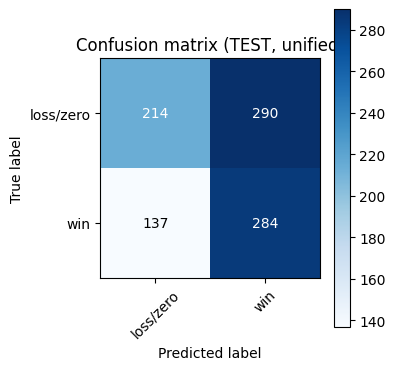

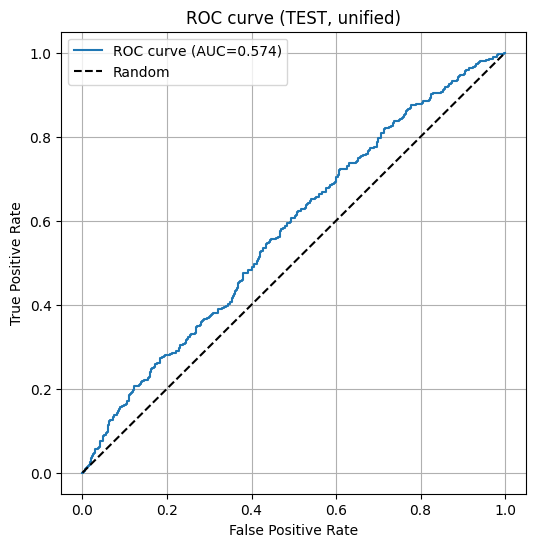

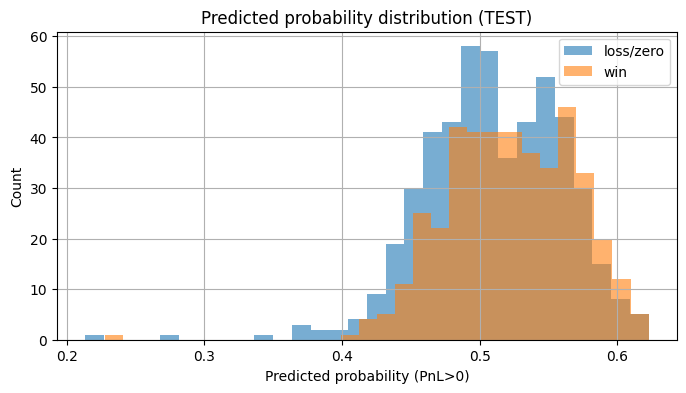

In [18]:
# %%
# Confusion matrix heatmap
plt.figure(figsize=(4, 4))
plt.imshow(cm, interpolation="nearest", cmap="Blues")
plt.title("Confusion matrix (TEST, unified)")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["loss/zero", "win"], rotation=45)
plt.yticks(tick_marks, ["loss/zero", "win"])

thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(
            j,
            i,
            format(cm[i, j], "d"),
            ha="center",
            va="center",
            color="white" if cm[i, j] > thresh else "black",
        )

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()

# ROC curve
fpr, tpr, thresholds_roc = roc_curve(labels_te, probs_te)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC={roc_auc:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve (TEST, unified)")
plt.legend()
plt.grid(True)
plt.show()

# Probability histograms
plt.figure(figsize=(8, 4))
plt.hist(probs_te[labels_te == 0], bins=30, alpha=0.6, label="loss/zero")
plt.hist(probs_te[labels_te == 1], bins=30, alpha=0.6, label="win")
plt.xlabel("Predicted probability (PnL>0)")
plt.ylabel("Count")
plt.title("Predicted probability distribution (TEST)")
plt.legend()
plt.grid(True)
plt.show()


In [19]:
# %% [markdown]
# ## 9. Strategy-level PnL on TEST (baseline vs prob>=0.5)
#
# TEST-only version of the PnL analysis in `model_trainer.ipynb`:
# - Baseline: execute **all** trades
# - Filtered: execute trades where `p(win) >= 0.5`


In [20]:
# %%
mask_long_te  = (is_short_te == 0)
mask_short_te = (is_short_te == 1)

# Baseline: all trades
baseline_test_pnl_long  = float(yusd_te[mask_long_te].sum())
baseline_test_pnl_short = float(yusd_te[mask_short_te].sum())
baseline_test_pnl_total = baseline_test_pnl_long + baseline_test_pnl_short

n_long_total  = int(mask_long_te.sum())
n_short_total = int(mask_short_te.sum())

print("=== Strategy-level PnL (TEST, baseline all trades) ===")
print(f"  LONG:  trades={n_long_total},  total PnL={baseline_test_pnl_long:.2f} USD")
print(f"  SHORT: trades={n_short_total}, total PnL={baseline_test_pnl_short:.2f} USD")
print(f"  TOTAL: trades={n_long_total + n_short_total}, total PnL={baseline_test_pnl_total:.2f} USD")

# Filtered: prob >= 0.5
take_long_05  = (probs_te >= 0.5) & mask_long_te
take_short_05 = (probs_te >= 0.5) & mask_short_te

pnl_long_05  = float(yusd_te[take_long_05].sum())
pnl_short_05 = float(yusd_te[take_short_05].sum())
pnl_total_05 = pnl_long_05 + pnl_short_05

n_long_taken_05  = int(take_long_05.sum())
n_short_taken_05 = int(take_short_05.sum())

print("\n=== Filtered execution (prob >= 0.5) ===")
print(f"  LONG:  taken={n_long_taken_05}/{n_long_total},  PnL_taken={pnl_long_05:.2f} USD")
print(f"  SHORT: taken={n_short_taken_05}/{n_short_total}, PnL_taken={pnl_short_05:.2f} USD")
print(f"  TOTAL: taken={n_long_taken_05 + n_short_taken_05}/{n_long_total + n_short_total}, "
      f"PnL_taken={pnl_total_05:.2f} USD")

profit_gain_05 = pnl_total_05 - baseline_test_pnl_total
print("\nNet effect vs baseline:")
print(f"  Profit gain (0.5): {profit_gain_05:.2f} USD")
if baseline_test_pnl_total != 0:
    print(f"  Relative: {100.0 * profit_gain_05 / abs(baseline_test_pnl_total):.2f}% of |baseline|")


=== Strategy-level PnL (TEST, baseline all trades) ===
  LONG:  trades=462,  total PnL=4304.18 USD
  SHORT: trades=463, total PnL=3882.53 USD
  TOTAL: trades=925, total PnL=8186.71 USD

=== Filtered execution (prob >= 0.5) ===
  LONG:  taken=418/462,  PnL_taken=-2221.68 USD
  SHORT: taken=156/463, PnL_taken=3461.37 USD
  TOTAL: taken=574/925, PnL_taken=1239.69 USD

Net effect vs baseline:
  Profit gain (0.5): -6947.02 USD
  Relative: -84.86% of |baseline|


In [21]:
# %% [markdown]
# ## 10. Profit-based threshold tuning (TEST, per direction)
#
# FIGYELEM: itt a küszöböt magán a TEST-en "hangoljuk", ez optimista (csak elemzésre!).
#
# LONG és SHORT külön:
# - küszöbök scan 0..1
# - PnL(thr) = összegzett y_usd a kiválasztott (p>=thr) trade-eken
# - best thr = ahol a PnL maximális


In [22]:
# %%
import pandas as pd

def threshold_sweep_for_direction(probs, yusd, mask_dir, thresholds):
    """
    probs: (N,) predicted probabilities
    yusd:  (N,) true net PnL in USD
    mask_dir: boolean mask for a direction (LONG or SHORT)
    thresholds: array-like of thresholds

    Returns:
      pnls:   (K,) pnl at each threshold
      trades: (K,) number of trades taken at each threshold
    """
    probs_d = probs[mask_dir]
    yusd_d  = yusd[mask_dir]

    pnls = np.zeros(len(thresholds), dtype=np.float64)
    trades = np.zeros(len(thresholds), dtype=np.int64)

    if probs_d.size == 0:
        return pnls, trades

    for i, thr in enumerate(thresholds):
        take = probs_d >= thr
        trades[i] = int(take.sum())
        pnls[i] = float(yusd_d[take].sum()) if trades[i] > 0 else 0.0

    return pnls, trades


def find_best_threshold_for_direction(probs, yusd, mask_dir, n_steps=201):
    """
    Returns: best_thr, best_pnl, trades_taken_at_best, sweep_df
    Tie-break: if same best_pnl, prefer HIGHER threshold (kevesebb trade).
    """
    thresholds = np.linspace(0.0, 1.0, n_steps)
    pnls, trades = threshold_sweep_for_direction(probs, yusd, mask_dir, thresholds)

    if len(thresholds) == 0:
        return 0.5, 0.0, 0, None

    best_pnl = np.max(pnls)
    best_idxs = np.where(pnls == best_pnl)[0]
    best_idx = int(best_idxs[-1])  # higher threshold on tie

    best_thr = float(thresholds[best_idx])
    best_trades = int(trades[best_idx])

    sweep_df = pd.DataFrame({
        "thr": thresholds,
        "pnl_taken": pnls,
        "trades_taken": trades,
    })

    return best_thr, float(best_pnl), best_trades, sweep_df


# Ensure masks exist (if you paste this elsewhere)
mask_long_te  = (is_short_te == 0)
mask_short_te = (is_short_te == 1)

baseline_test_pnl_long  = float(yusd_te[mask_long_te].sum())
baseline_test_pnl_short = float(yusd_te[mask_short_te].sum())

thr_long, best_test_pnl_long, best_test_trades_long, sweep_long = find_best_threshold_for_direction(
    probs_te, yusd_te, mask_long_te, n_steps=201
)
thr_short, best_test_pnl_short, best_test_trades_short, sweep_short = find_best_threshold_for_direction(
    probs_te, yusd_te, mask_short_te, n_steps=201
)

print("=== TEST PnL and best thresholds (tuned on TEST) ===")
print("LONG:")
print(f"  Baseline PnL (all trades): {baseline_test_pnl_long:.2f} USD")
print(f"  Best thr: {thr_long:.3f}, PnL_taken: {best_test_pnl_long:.2f} USD, "
      f"trades taken: {best_test_trades_long}/{int(mask_long_te.sum())}")

print("\nSHORT:")
print(f"  Baseline PnL (all trades): {baseline_test_pnl_short:.2f} USD")
print(f"  Best thr: {thr_short:.3f}, PnL_taken: {best_test_pnl_short:.2f} USD, "
      f"trades taken: {best_test_trades_short}/{int(mask_short_te.sum())}")


=== TEST PnL and best thresholds (tuned on TEST) ===
LONG:
  Baseline PnL (all trades): 4304.18 USD
  Best thr: 0.400, PnL_taken: 4477.03 USD, trades taken: 461/462

SHORT:
  Baseline PnL (all trades): 3882.53 USD
  Best thr: 0.445, PnL_taken: 6306.28 USD, trades taken: 412/463


In [23]:
# %% [markdown]
# ## 11. Strategy-level PnL on TEST with tuned thresholds (from TEST sweep)
# - LONG: execute if p >= thr_long
# - SHORT: execute if p >= thr_short
# and compare vs baseline


In [24]:
# %%
take_long  = (probs_te >= thr_long)  & mask_long_te
take_short = (probs_te >= thr_short) & mask_short_te

pnl_long_taken   = float(yusd_te[take_long].sum())
pnl_short_taken  = float(yusd_te[take_short].sum())
pnl_total_taken  = pnl_long_taken + pnl_short_taken

pnl_long_skipped  = float(yusd_te[mask_long_te & (~take_long)].sum())
pnl_short_skipped = float(yusd_te[mask_short_te & (~take_short)].sum())
pnl_total_skipped = pnl_long_skipped + pnl_short_skipped

n_long_taken   = int(take_long.sum())
n_short_taken  = int(take_short.sum())
n_long_total   = int(mask_long_te.sum())
n_short_total  = int(mask_short_te.sum())
n_long_skipped = n_long_total - n_long_taken
n_short_skipped = n_short_total - n_short_taken

baseline_test_pnl_total = baseline_test_pnl_long + baseline_test_pnl_short

print("=== Strategy-level PnL (TEST, tuned thresholds) ===")
print("Baseline (all trades executed):")
print(f"  LONG:  trades={n_long_total},  total PnL={baseline_test_pnl_long:.2f} USD")
print(f"  SHORT: trades={n_short_total}, total PnL={baseline_test_pnl_short:.2f} USD")
print(f"  TOTAL: trades={n_long_total + n_short_total}, total PnL={baseline_test_pnl_total:.2f} USD")

print("\nFiltered (p >= thr_long for LONG, p >= thr_short for SHORT):")
print(f"  LONG:  taken={n_long_taken},  skipped={n_long_skipped}, "
      f"Pnl_taken={pnl_long_taken:.2f} USD, Pnl_skipped={pnl_long_skipped:.2f} USD")
print(f"  SHORT: taken={n_short_taken}, skipped={n_short_skipped}, "
      f"Pnl_taken={pnl_short_taken:.2f} USD, Pnl_skipped={pnl_short_skipped:.2f} USD")
print(f"  TOTAL: taken={n_long_taken + n_short_taken}, "
      f"skipped={n_long_skipped + n_short_skipped}, "
      f"Pnl_taken={pnl_total_taken:.2f} USD, Pnl_skipped={pnl_total_skipped:.2f} USD")

profit_gain = pnl_total_taken - baseline_test_pnl_total
print("\nNet effect vs baseline:")
print(f"  Profit gain: {profit_gain:.2f} USD")
if baseline_test_pnl_total != 0:
    print(f"  Relative: {100.0 * profit_gain / abs(baseline_test_pnl_total):.2f}% of |baseline|")


=== Strategy-level PnL (TEST, tuned thresholds) ===
Baseline (all trades executed):
  LONG:  trades=462,  total PnL=4304.18 USD
  SHORT: trades=463, total PnL=3882.53 USD
  TOTAL: trades=925, total PnL=8186.71 USD

Filtered (p >= thr_long for LONG, p >= thr_short for SHORT):
  LONG:  taken=461,  skipped=1, Pnl_taken=4477.03 USD, Pnl_skipped=-172.85 USD
  SHORT: taken=412, skipped=51, Pnl_taken=6306.28 USD, Pnl_skipped=-2423.75 USD
  TOTAL: taken=873, skipped=52, Pnl_taken=10783.31 USD, Pnl_skipped=-2596.60 USD

Net effect vs baseline:
  Profit gain: 2596.60 USD
  Relative: 31.72% of |baseline|


In [25]:
# %% [markdown]
# ## 12. Comparison with simple 0.5 threshold (optional)


In [26]:
# %%
take_long_05  = (probs_te >= 0.5) & mask_long_te
take_short_05 = (probs_te >= 0.5) & mask_short_te

pnl_long_05  = float(yusd_te[take_long_05].sum())
pnl_short_05 = float(yusd_te[take_short_05].sum())
pnl_total_05 = pnl_long_05 + pnl_short_05

print("=== Simple threshold 0.5 vs tuned thresholds (TEST) ===")
print("prob >= 0.5:")
print(f"  LONG PnL:  {pnl_long_05:.2f} USD")
print(f"  SHORT PnL: {pnl_short_05:.2f} USD")
print(f"  TOTAL:     {pnl_total_05:.2f} USD")

print("\nTuned thresholds (from TEST sweep):")
print(f"  LONG thr={thr_long:.3f},  PnL={pnl_long_taken:.2f} USD")
print(f"  SHORT thr={thr_short:.3f}, PnL={pnl_short_taken:.2f} USD")
print(f"  TOTAL:               {pnl_total_taken:.2f} USD")


=== Simple threshold 0.5 vs tuned thresholds (TEST) ===
prob >= 0.5:
  LONG PnL:  -2221.68 USD
  SHORT PnL: 3461.37 USD
  TOTAL:     1239.69 USD

Tuned thresholds (from TEST sweep):
  LONG thr=0.400,  PnL=4477.03 USD
  SHORT thr=0.445, PnL=6306.28 USD
  TOTAL:               10783.31 USD


In [27]:
# %% [markdown]
# ## 13. (Optional) Plot threshold sweep curves (PnL vs threshold)


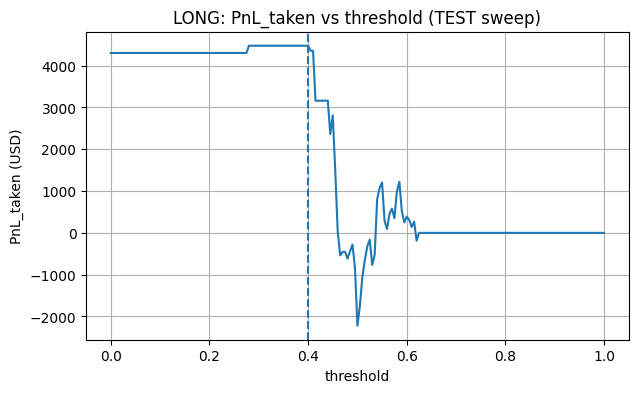

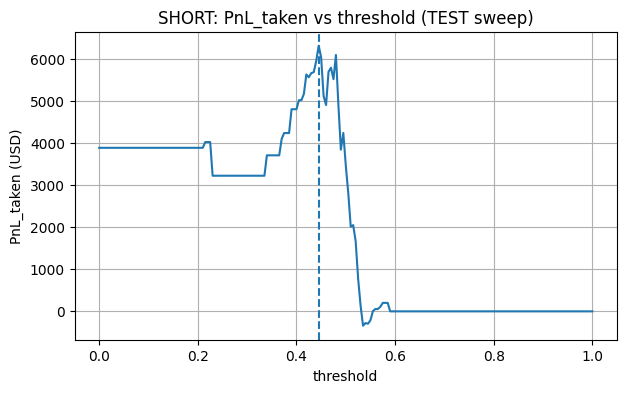

In [28]:
# %%
if sweep_long is not None:
    plt.figure(figsize=(7, 4))
    plt.plot(sweep_long["thr"], sweep_long["pnl_taken"])
    plt.axvline(thr_long, linestyle="--")
    plt.title("LONG: PnL_taken vs threshold (TEST sweep)")
    plt.xlabel("threshold")
    plt.ylabel("PnL_taken (USD)")
    plt.grid(True)
    plt.show()

if sweep_short is not None:
    plt.figure(figsize=(7, 4))
    plt.plot(sweep_short["thr"], sweep_short["pnl_taken"])
    plt.axvline(thr_short, linestyle="--")
    plt.title("SHORT: PnL_taken vs threshold (TEST sweep)")
    plt.xlabel("threshold")
    plt.ylabel("PnL_taken (USD)")
    plt.grid(True)
    plt.show()
